# Data Science Challenge

May, 2018 - Christoph Hilty

### Preface

This notebook contains the complete code, data exploration steps and thought processes for all the parts of the challenge. I decided not to extract any code in modules or classes so that any written code can be directly seen in the notebook. 
For a presentation in front of the customer, visualizations (possibly interactive) without the code should be considered (e.g. with sumologic, datadog or plot.ly).

### Worktime calculation

$$\large w_t = \bar{r}_n * n_c $$

($ w_t $ = worktime,
$ r_t $ = response time,
$ n_c $ = throughput / number of service calls)


Note: Possibly inconsistend definition of worktime in challenge (Sum of response time or number of requests times average response time).

### Side note

Because the data is from a deterministic process is a periodic signal there are some special conditions and approaches to be considered:
* We cannot feed our model unseen data because any data is a repetition of previous data. The splitting of the train and testing data is therefore different and somewhat odd because no overfitting is expected.
* Some statistical method (e.g. analysis of residuals) are not of much help because the data contains no noise and the residuals are not normally distributed.
* The best way to further approach the problem would be trough fourier transformation, allowing us to decompose the data into fourier series and convert the time function into frequency components.

### Content

1. Data preprocessing and visualization
2. Time series forecasting
    * Average response time
        * Seasonal decomposition
        * Forecast
    * Throughput
        * Seasonal decomposition
        * Forecast
    3. Worktime
        * Seasonal decomposition
        * Forecast
        * Forecast with LSTM (Variation)
3. Correlation of the layers

### 1. Data preprocessing and visualization

** Next steps **
* Correct the invalid formatting of the json files
* Load the data into memory
* Print statistics and overview of data
* Check for missing values
* Print involved applications, function- and technical components.

In [1]:
import pandas as pd

# Import the data
application_events = pd.read_json('D:\\events\\applications.json')

# Print overview
application_events.head(3)

,appIdConsumer,appIdProvider,beatId,beatType,callId,callMode,callScope,correlationId,durationMs,eventTime,...,orgBezeichnung,orgId,orgKurzbezeichnung,orgSubkategorien,parentCallId,role,stage,tkNameIdConsumer,tkNameIdProvider,userId
0,spoud-app,sim-provider,0,ServiceProviderBeat,0,SYNC,LOCAL,6ee2fa2b-a1ca-405e-9088-94dbb834730f,201,2018-05-05T07:55:38.422185+00:00,...,Bellinzona,na,na,GA,superloser,provider,SIM,spoud-portal,tm4-Mond-52,SIMU147400
1,spoud-app,sim-provider,2,ServiceProviderBeat,2,SYNC,LOCAL,7aa2e01f-4af6-48e8-ae98-a42fe9fc6e5d,201,2018-05-05T07:55:38.432086+00:00,...,Lyss,na,na,GA,superloser,provider,SIM,spoud-portal,tm4-Mond-52,SIMU534284
2,spoud-app,sim-provider,4,ServiceProviderBeat,4,SYNC,LOCAL,f722a638-7e0d-4f19-86ad-7aeecbffa40f,201,2018-05-05T07:55:38.441987+00:00,...,Winterthur,na,na,GA,superloser,provider,SIM,spoud-portal,tm4-Mond-52,SIMU816207


In [2]:
# Print some initial statistics
application_events['durationMs'].describe()

count    1.296000e+06
mean     3.598675e+02
std      1.350601e+02
min      2.000000e+02
25%      2.690000e+02
50%      3.400000e+02
75%      4.250000e+02
max      1.955000e+03
Name: durationMs, dtype: float64

In [3]:
# Check for missing values
null_values = application_events.isnull().sum()
print('Number of NA/NaN\'s: %s' % null_values[null_values != 0].count())

Number of NA/NaN's: 0


In [4]:
# Print overview of involved components
id_fields = ['appIdProvider', 'fkNameProvider', 'tkNameIdProvider']
unique_components = zip([id_field for id_field in id_fields], 
                        ['Application', 'Functional component', 'Technical component'])
for field, name in unique_components:
    unique_components = application_events[field].unique()
    print('%d %s\'s:' % (unique_components.size, name), end=' ')
    print(', '.join(str(c) for c in unique_components))

1 Application's: sim-provider
1 Functional component's: fkNameProvider
18 Technical component's: tm4-Mond-52, tm4-Phobos-52, tm4-Deimos-52, tm4-Adrastea-52, tm4-Metis-52, tm4-Amalthea-52, tm4-Thebe-52, tm4-Io-52, tm4-Europa-52, tm4-Ganymed-52, tm4-Kallisto-52, tm4-Themisto-52, tm4-Leda-52, tm4-Himalaia-52, tm4-Lysithea-52, tm4-Elara-52, tm4-Carpo-52, tm4-Euporie-52


** Next steps **
* Create correct index for events
* Convert data types
* Identify involved time frame
* Build dictionary with one minute buckets per component

In [5]:
# Filter only relevant information and correct index
performance = application_events[['tkNameIdProvider', 'durationMs', 'eventTime']]
performance = performance.set_index('eventTime')
performance.index = pd.to_datetime(performance.index)

In [6]:
# Inspect time frame
start, end, duration = performance.index.min(), performance.index.max(), performance.index.max() - performance.index.min() 
print('Time frame: %s to %s (%s)' % (start.strftime("%Y-%m-%d %H:%M:%S"), end.strftime("%Y-%m-%d %H:%M:%S"), duration))

Time frame: 2018-05-05 07:55:38 to 2018-05-05 19:54:39 (0 days 11:59:00.993711)


In [7]:
# Build a dicitionary with all components
all_components = {}

# Method for building statistics for group
def aggregate_stats(group):
    number_of_requests = group_component.count()
    total_duration = group_component.sum()
    avg_response_time = total_duration / number_of_requests
    # (Alternate definition in document: worktime = avg_response_time * number_of_requests)
    performance_of_component = pd.DataFrame({'component_name': technical_component,  
                                             'worktime' : total_duration, 
                                             'throughput' : number_of_requests, 
                                             'response_time' : avg_response_time})
    return performance_of_component

for technical_component in performance['tkNameIdProvider'].unique():       
    group_component = performance.loc[performance['tkNameIdProvider'] == technical_component] \
        .resample('1T')['durationMs']
    all_components[technical_component] = aggregate_stats(group_component)

** Next steps **
* Plot performance overview for all components
* Identify obtrusive component and time frame
* Plot detail of critical data

In [8]:
def create_thousand_formatter():
    locale.setlocale(locale.LC_ALL, 'de-CH')
    thousand_formatter = plt.FuncFormatter(lambda x, _ : locale.format("%d", x, grouping=True))
    return thousand_formatter

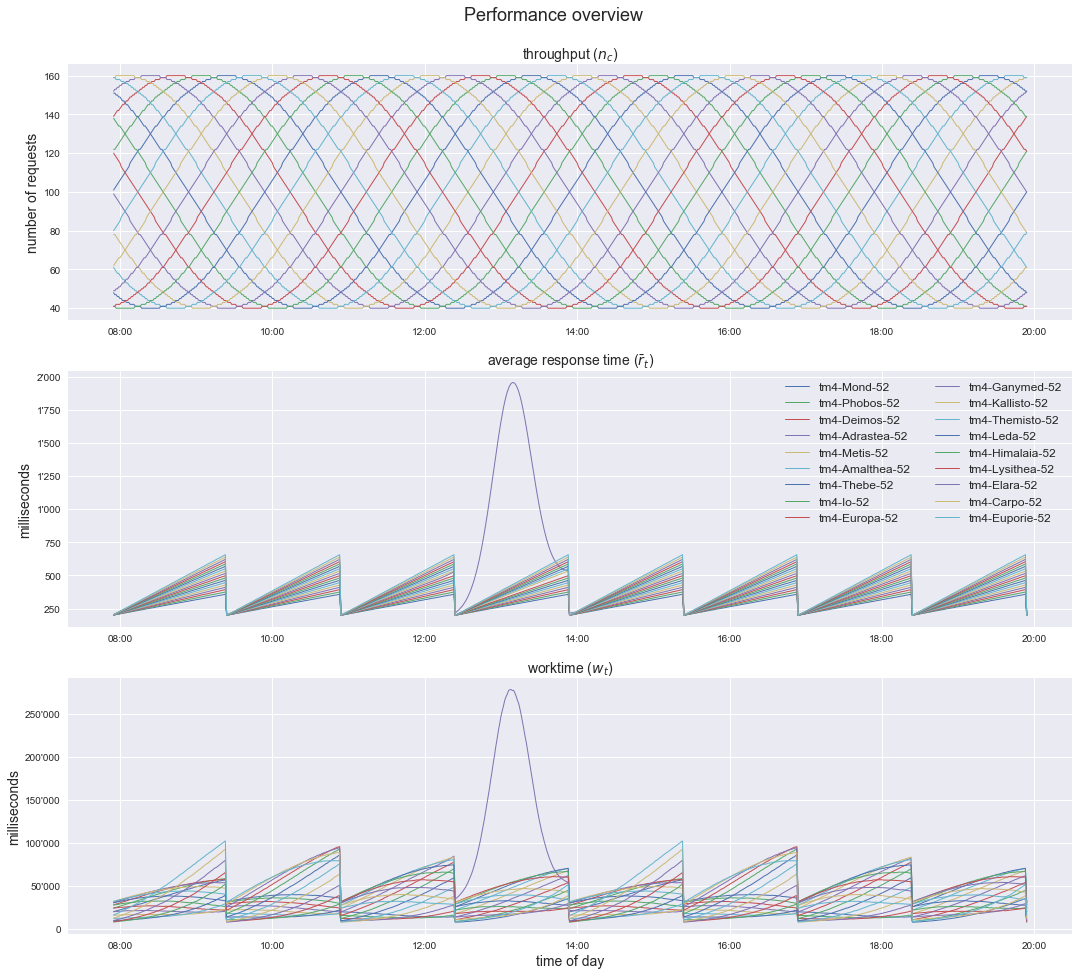

In [18]:
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import locale
import numpy as np

# Set searborn style for plot
plt.style.use('seaborn')
thousand_formatter = create_thousand_formatter()
hour_formatter = mdates.DateFormatter("%H:%M")

# Plot metrics for all components for comparision
fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(18,16))
plt.suptitle('Performance overview', fontsize=18, y=.93)

for component in all_components.values():
    
    ax1.plot(component['throughput'], linewidth=1)
    ax1.set_title('throughput ($ n_c $)', fontsize=14)
    ax1.set_ylabel('number of requests', fontsize=14)
    ax1.xaxis.set_major_formatter(hour_formatter)    
    
    ax2.plot(component['response_time'], linewidth=1)
    ax2.set_title('average response time ($ \\bar{r}_t $)', fontsize=14)
    ax2.yaxis.set_major_formatter(thousand_formatter)
    ax2.set_ylabel('milliseconds', fontsize=14)
    ax2.xaxis.set_major_formatter(hour_formatter)    
    
    ax3.plot(component['worktime'], linewidth=1)
    ax3.set_title('worktime ($ w_t $)', fontsize=14)
    ax3.set_ylabel('milliseconds', fontsize=14)
    ax3.xaxis.set_major_formatter(hour_formatter)    
    ax3.yaxis.set_major_formatter(thousand_formatter)
    ax3.set_xlabel('time of day', fontsize=14)

ax2.legend(all_components.keys(), ncol=2, prop={'size': 12})
plt.show()

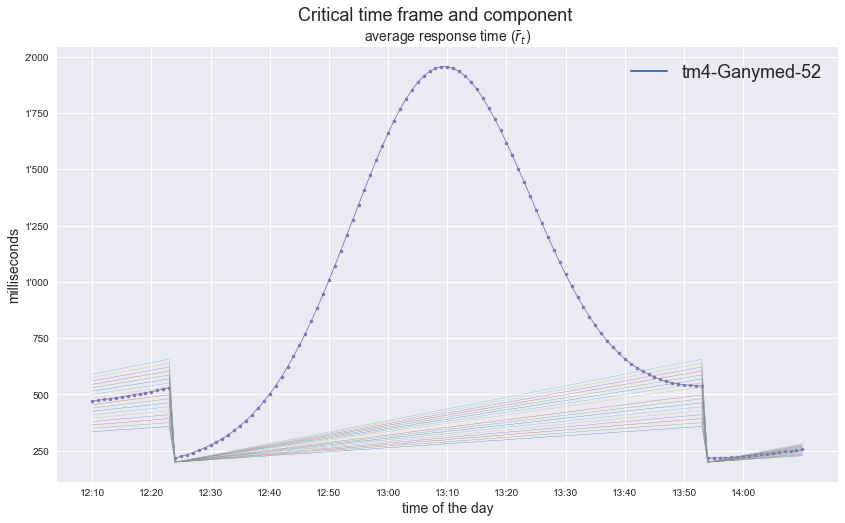

In [19]:
import datetime as dt

# Create clean labels
start = dt.datetime(2018, 5, 5, 12, 10, 0)
end = dt.datetime(2018, 5, 5, 14, 10, 0)
step = dt.timedelta(minutes=10)
hour_format = '%Y-%m-%d %H:%M:%S'

result = []
time = start
while time < end:
    result.append(time.strftime(hour_format))
    time += step
    
# Have a closer look at the critical time
fig, ax = plt.subplots(1, 1, sharex=True, figsize=(14,8))
plt.suptitle('Critical time frame and component', fontsize=18, y=.95)
for name, component in all_components.items():
    
    ax.plot(component[start.strftime(hour_format):end.strftime(hour_format)]['response_time'], 
            '.-' if name == 'tm4-Ganymed-52' else '-',
            linewidth=.8 if name == 'tm4-Ganymed-52' else .3)
    ax.set_title('average response time ($ \\bar{r}_t $)', fontsize=14)
    ax.set_ylabel('milliseconds', fontsize=14)
    ax.set_xlabel('time of the day', fontsize=14)
    ax.xaxis.set_major_formatter(hour_formatter)    
    ax.yaxis.set_major_formatter(thousand_formatter)
    ax.set_xticks(result, minor=False)
    
leg = ax.legend(['tm4-Ganymed-52'], ncol=2, prop={'size': 18})
for h in leg.legendHandles:
    h.set_linewidth(2.0)
    
plt.show()

The technical component tm4-Ganymed-52 is obviously behaving unexpectedly. An obtrusive increase in response time between around 12:24 and 13:53 with a peak around 13:10. We advice double checking the technical component for problems.

### 2. Time series forecasting

** Next steps **
* Choose component 
* Plot overview of the different time series
* Inspect series for trends and seasonalities

In [20]:
# Choose component for forecasting
chosen_component_id = 'tm4-Himalaia-52'

In [21]:
chosen_component = all_components[chosen_component_id]
chosen_component.head()

,component_name,response_time,throughput,worktime
eventTime,,,,
2018-05-05 07:55:00,tm4-Himalaia-52,204.0,41,8364
2018-05-05 07:56:00,tm4-Himalaia-52,208.0,41,8528
2018-05-05 07:57:00,tm4-Himalaia-52,213.0,40,8520
2018-05-05 07:58:00,tm4-Himalaia-52,217.0,40,8680
2018-05-05 07:59:00,tm4-Himalaia-52,221.0,40,8840


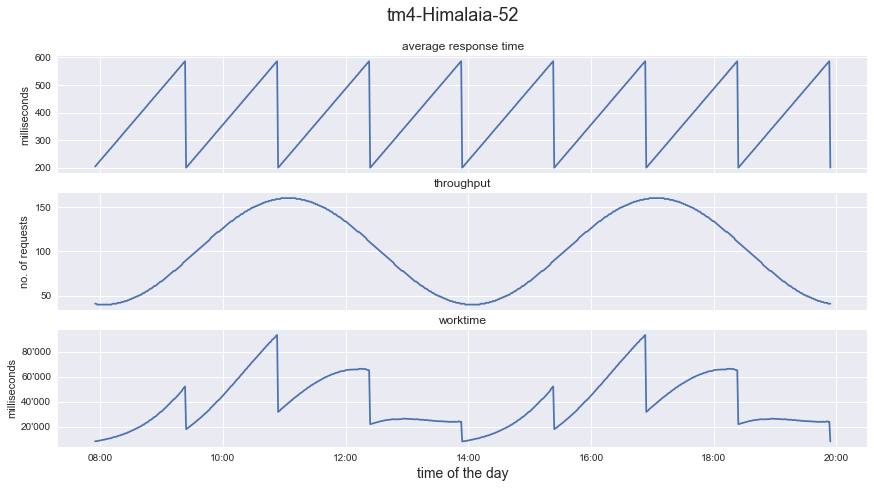

In [29]:
fig, (ax1, ax2, ax3) = plt.subplots(3, 1, sharex=True, figsize=(12, 6))

plt.tight_layout()
plt.suptitle(chosen_component_id, fontsize=18, y=1.08)

ax1.plot(chosen_component['response_time'])
ax1.set_title('average response time')
ax1.set_ylabel('milliseconds')

ax2.plot(chosen_component['throughput'])
ax2.set_title('throughput')
ax2.set_ylabel('no. of requests')

ax3.plot(chosen_component['worktime'])
ax3.set_title('worktime')
ax3.yaxis.set_major_formatter(thousand_formatter)
ax3.set_ylabel('milliseconds')
    
ax3.xaxis.set_major_formatter(hour_formatter)    
ax3.set_xlabel('time of the day', fontsize=14)
plt.show()

Average response time and troughput show a clear indication of sesonality and no signs of a long-term trend. Because there is a linear increase in respone time a multiplicative model for decomposition has been chosen. 

### 2.1 Average response time

#### 2.1.1 Seasonal decomposition of average response time

** Next steps **
* Inspect autocorrelation and partialautocorrelation
* Perform seasonal decomposition of time serie
* Determine frequency of seasonality

In [30]:
def plot_correlation(data):
    fig, (ax1, ax2) = plt.subplots(1,2, figsize=(16, 5))
    plot_acf(data, alpha=.05, lags=(2*60), ax=ax1)
    plot_pacf(data, alpha=.05, lags=(2*60), ax=ax2)
    plt.show()
    print('Autocorrelation is: %4.2f' % data.autocorr())

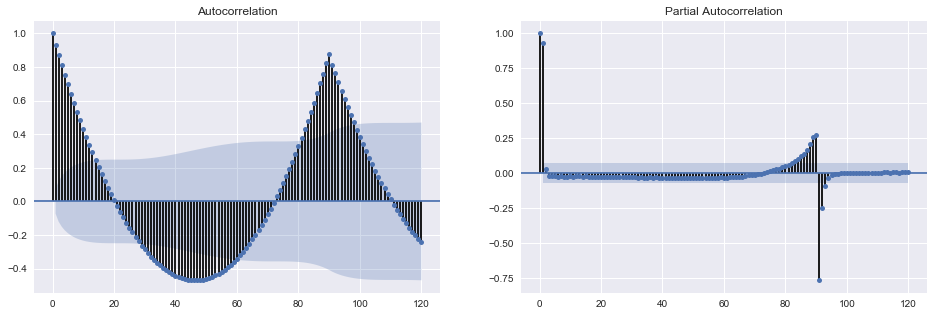

Autocorrelation is: 0.93


In [32]:
from statsmodels.tsa.stattools import acf
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

response_times = chosen_component['response_time']

# Examine autocorrelation and partial autocorrelation of the response times
plot_correlation(response_times)

As expected there is a heavy autocorrelation in the average response times and the plot for the partial autocorrelation suggests a frequency for seasonality of around 90.

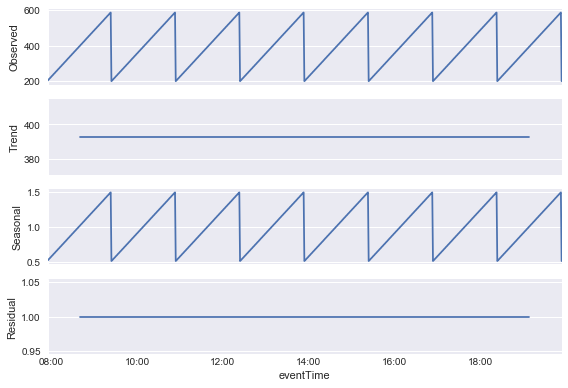

In [33]:
import statsmodels.api as sm

# Plot the decomposition of the time series
response_time_components = sm.tsa.seasonal_decompose(chosen_component['response_time'], model='multiplicative', freq=90)
response_time_components.plot()
plt.show()

With the determined frequency the progression of the average response times can be completly isolated in a seasonal component.

#### 2.1.2 Generating a forecast for response time

** Next steps **
* Choose base model
* Split the data in train and test sets
* Perform grid search over relevant parameters
* Choose information criterion
* Choose best performing model

In [34]:
# Because the data is artifical we choose 60/40 split 
def train_test_split(data, percentage=.6):
    split_minute = data.index[0] + dt.timedelta(minutes=(12 * 60) * percentage)
    train_data = data[:split_minute]
    test_data = data.iloc[train_data.count():]
    print("Training data: %s rows" % train_data.count())
    print("Testing data: %s rows" % test_data.count())
    return (train_data, test_data)

In [56]:
train_data, test_data = train_test_split(response_times)

Training data: 433 rows
Testing data: 287 rows


In [57]:
import itertools
import warnings

# Function for grid search over seasonal parameters of a SARIMAX model
def sarimax_grid_search(data, seasonality_lag, plot_progress = False):
    
    # Because not all parameter of a grid search work, we disable warnings
    warnings.filterwarnings('ignore')

    max_param = 2
    p=d=q = range(0, max_param)

    bic = aic = {}

    # Initialize cartesian product for seasonal parameters (with fix lag for seasonality)
    seasonal_pdq = [(x[0], x[1], x[2], seasonality_lag) for x in list(itertools.product(p, d, q))]
    
    # Performing a grid search over the different parameters evaluate their information criterias
    for seasonal_model in seasonal_pdq:
        try:
            mod = sm.tsa.statespace.SARIMAX(data,
                                            order=(0,0,0),
                                            seasonal_order=seasonal_model,
                                            enforce_stationarity=False,
                                            enforce_invertibility=False)

            result = mod.fit()
            if plot_progress:
                print('SARIMAX %sx%s' % ('(0, 0, 0)', (seasonal_model)), end=' ')
                print('-- AKAIKE: %s, BIC: %s' % (result.aic, result.bic))
            key = '%sx%s' % ('(0, 0, 0)', (seasonal_model))
            bic[key] = result.bic
            aic[key] = result.aic
        except:
            continue
                
    warnings.filterwarnings('default')
    
    best_model = min(aic, key=aic.get)
    return (bic, aic, best_model)

We choose the akaike information criterion as performance measurement because the bayesian and the akaike information criterion are suggesting same order of models.

In [58]:
# Perform grid search and get best model
bic, aic, best_model = sarimax_grid_search(train_data, 90, True)

SARIMAX (0, 0, 0)x(0, 0, 1, 90) -- AKAIKE: 12923.3839733, BIC: 12931.5254488
SARIMAX (0, 0, 0)x(1, 0, 1, 90) -- AKAIKE: -20137.2137808, BIC: -20125.0015676


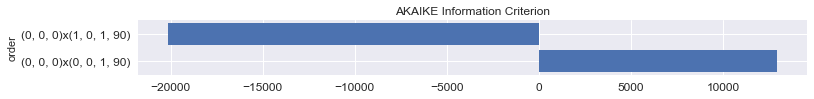

In [60]:
# Print different models with their akaike information criterion
fit, ax1 = plt.subplots(1, sharex=True, figsize=(12, 1))

ax1.tick_params(labelsize=12)
ax1.barh(range(len(aic.keys())), aic.values(), 
        tick_label=aic.keys())
ax1.set_title('AKAIKE Information Criterion')
ax1.set_ylabel('order')

plt.show()

In [61]:
# Print performance of model with lowest information criteria
print("Best performing model %s: %s (BIC) / %s (AKAIKE)" % (best_model,
      bic[best_model], aic[best_model]))

Best performing model (0, 0, 0)x(1, 0, 1, 90): -20137.2137808 (BIC) / -20137.2137808 (AKAIKE)


The best model is a SARIMAX (Seasonal AutoRegressive Integrated Moving Averages with eXogenous regressors) of order (0, 0, 0)x(1, 0, 1, 90). This makes sense, because there are no residuals in our model and it can be explained by the seasonal components only-

** Next steps **
* Fitting chosen model to training data
* Inspect trained model
* Performing forecast
* Calculating metrics of model

In [62]:
# Function for fitting an sarimax model
def fit_arimax_model(data, order, seasonal_order):
    
    warnings.filterwarnings('ignore')
    results = None

    # We fit the model with our parameters from the grid search
    mod = sm.tsa.statespace.SARIMAX(data,
                                    order=order,
                                    seasonal_order=seasonal_order,
                                    enforce_stationarity=False,
                                    enforce_invertibility=False)
    results = mod.fit()

    warnings.filterwarnings('default')
    return results

In [63]:
# Fitting the best performaing model
results = fit_arimax_model(train_data, (0, 0, 0), (1, 0, 1, 90)) 

In [64]:
# Print some statistics of our model
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            Statespace Model Results                            
================================================================================
Dep. Variable:            response_time   No. Observations:                  433
Model:             SARIMAX(1, 0, 1, 90)   Log Likelihood               10071.607
Date:                  Di., 22 Mai 2018   AIC                         -20137.214
Time:                          12:52:25   BIC                         -20125.002
Sample:                      05-05-2018   HQIC                        -20132.393
                           - 05-05-2018                                         
Covariance Type:                    opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.S.L90       1.0000   3.16e-17   3.16e+16      0.000       1.000       1.000
ma.S.L90      -0.0186   3.71e-21  -5.01e+18      0.000      -0.019      -0.019
sigma2      3.959e-27   1.05e-10   3.78e-17      1.000   -2.05e-10    2.05e-10
===================================================================================
Ljung-Box (Q):                      338.72   Jarque-Bera (JB):              9138.47
Prob(Q):                              0.00   Prob(JB):                         0.00
Heteroskedasticity (H):               0.00   Skew:                             4.65
Prob(H) (two-sided):                  0.00   Kurtosis:                        26.55
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 6.14e+32. Standard errors may be unstable.
"""

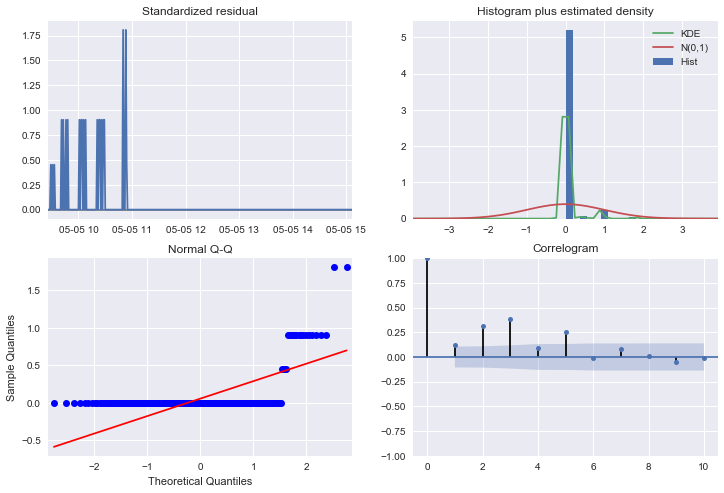

In [65]:
# Print some diagnostics for the residuals (not of much help, because we lack residuals)
results.plot_diagnostics(figsize=(12, 8))

The parameters of our model are all significant so wee keep them. The results of our model clearly state, that the residuals are not normal distributed. In a normal case, this would mean, that the model can be further improved. Due the artifical nature of the data, we keep our model.

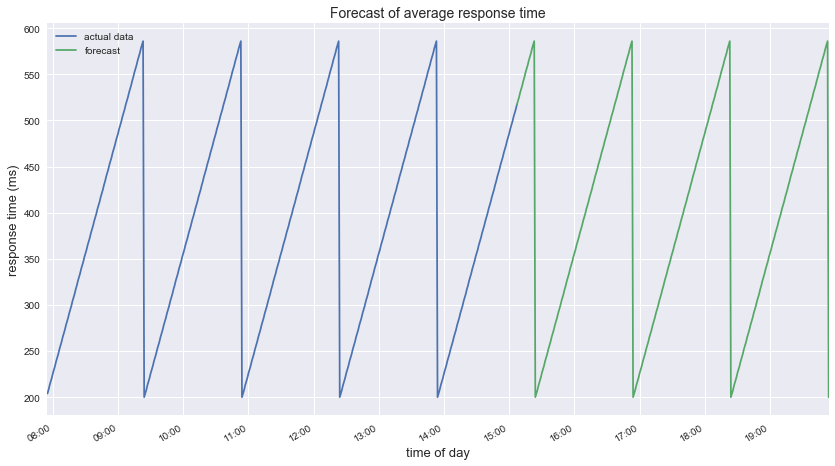

In [68]:
# Performing a one step ahead forecast
pred = results.get_prediction(start='2018-05-05 15:07:00', end='2018-05-05 19:54:00', dynamic=False)

fig, ax = plt.subplots(1, 1, figsize=(14,8))

ax.plot(train_data)
pred.predicted_mean.plot(ax=ax, label='forecast')
ax.set_ylabel('response time (ms)', fontsize=13)
ax.set_xlabel('time of day', fontsize=13)
ax.xaxis.set_major_formatter(hour_formatter)

plt.title('Forecast of average response time', fontsize=14)
plt.legend(['actual data', 'forecast'])
plt.show()

In [69]:
def calculate_mse(actual, predicted):
    mse = ((actual - predicted) ** 2).mean()
    print('The MSE of our forecast is %s' % mse)

In [70]:
# Calculate the mean sqaured error of our predition
calculate_mse(pred.predicted_mean, test_data)

The MSE of our forecast is 0.0


Due to the artifical data, the amount of training data and the perfect seasonality we have a model which perfectly predicts the the test data.

### 2.2 Throughput (number of requests)

#### 2.2.1 Seasonal decomposition of throughput

** Next steps **
* Inspect autocorrelation and partialautocorrelation
* Perform seasonal decomposition of time serie
* Determine frequency of seasonality

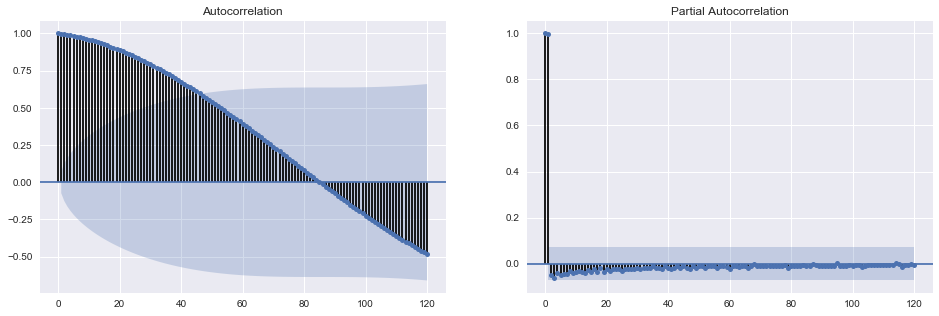

Autocorrelation is: 1.00


In [71]:
throughput = chosen_component['throughput']

# Examine autocorrelation and partial autocorrelation of the throughput
plot_correlation(throughput)

Due to the well-defined periodic nature of the signal, the autocorrelation is even 1.00. The partial autocorrelation cannot be seen in the partial auto correlation function but can be determiend by looking at the wave spread.

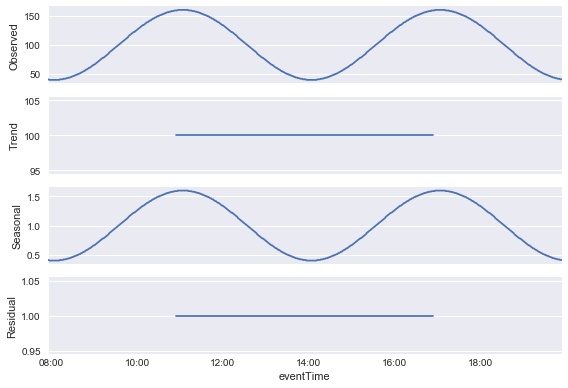

In [72]:
# Plot the decomposition of the throughput
throughput_components = sm.tsa.seasonal_decompose(throughput, model='multiplicative', freq=360)
throughput_components.plot()
plt.show()

Same as with the average response time, the data can be decomposed in only seasonal variance. The frequency of the seasonality is 360 minutes, corresponding to six hours.

#### 2.2.2 Forecast of throughput

** Next steps **
* Resample the data in 10 minute buckets due to seasonalit
* Split the data in train and test sets
* Perform grid search over relevant parameters
* Choose best performing model
* Create forecast

In [73]:
troughput_resampled = throughput.resample('10T').sum()['2018-05-05 08:00:00':'2018-05-05 19:40:00']

In [74]:
# Performing split for throughput
train_data, test_data = train_test_split(troughput_resampled, .9)

Training data: 65 rows
Testing data: 6 rows


In [75]:
# Grid search over parameters for sarimax model
bic, aic, best_model = sarimax_grid_search(train_data, 36)
print('Best SARIMAX model: %s' % best_model)

Best SARIMAX model: (0, 0, 0)x(1, 0, 0, 36)


In [76]:
# Fitting the best performaing model
results = fit_arimax_model(train_data, (0,0,0), ((1, 0, 0, 36)))

In [84]:
# Performing a one step ahead forecast
def make_prediction(data, fitted_model, title, y_axis = 'response time (ms)'):
    pred = fitted_model.get_prediction(start='2018-05-05 18:40:00', end='2018-05-05 23:59:00', dynamic=False)
    fig, ax = plt.subplots(1, 1, figsize=(12,8))
    ax.plot(data)
    pred.predicted_mean.plot(ax=ax, label='forecast')
    ax.set_ylabel(y_axis)
    ax.set_xlabel('time of day')
    ax.xaxis.set_major_formatter(hour_formatter)
    ax.yaxis.set_major_formatter(thousand_formatter)
    ax.axvspan('2018-05-05 18:40:00', '2018-05-05 19:40:00', color='blue', alpha=.1)

    plt.title(title, fontsize=14)
    plt.legend()
    plt.show() 

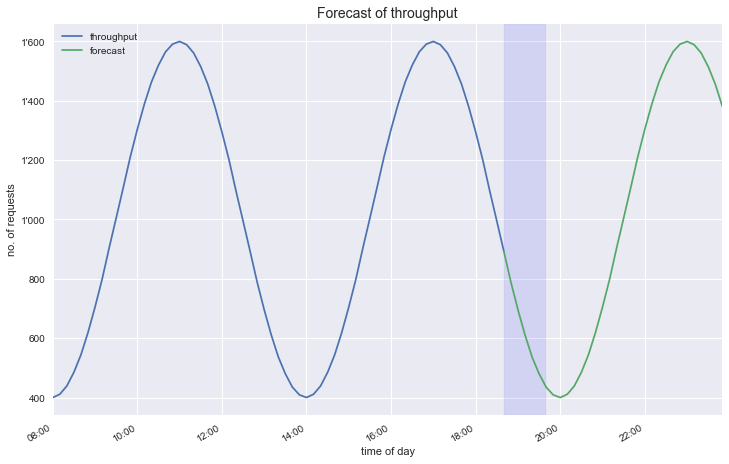

In [85]:
# Plot prediction
make_prediction(train_data, results, 'Forecast of throughput', 'no. of requests')

In [86]:
# Calculate the mean squred error of our predition for the test set
pred = results.get_prediction(start='2018-05-05 18:40:00', end='2018-05-05 19:40:00', dynamic=False)

calculate_mse(pred.predicted_mean, test_data)

The MSE of our forecast is 2.8542039365436504e-26


We have a minimal error in our resampled model as result of our resampling procedure. 

### 2.3 Worktime

#### 2.3.1 Seasonal decomposition of worktime

** Next steps **
* Inspect autocorrelation and partialautocorrelation
* Perform seasonal decomposition of time serie
* Determine frequency of seasonality

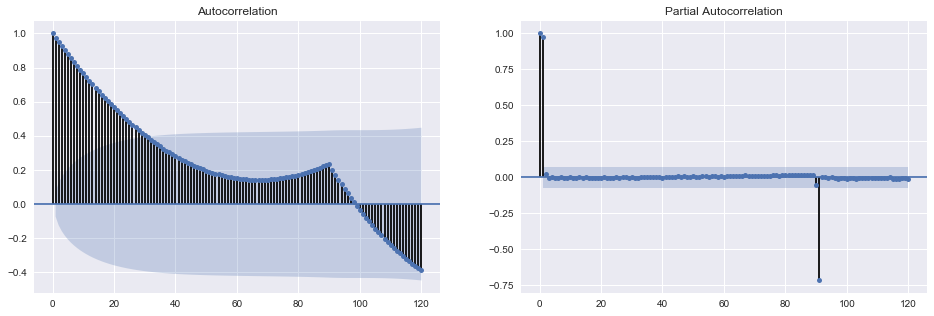

Autocorrelation is: 0.98


In [87]:
worktime = chosen_component['worktime']

# Examine autocorrelation and partial autocorrelation of the worktime
plot_correlation(worktime)

Because worktime is a composition of response time and throughput, the model shows similar properties and we can reuse the frequency of the seasonality.

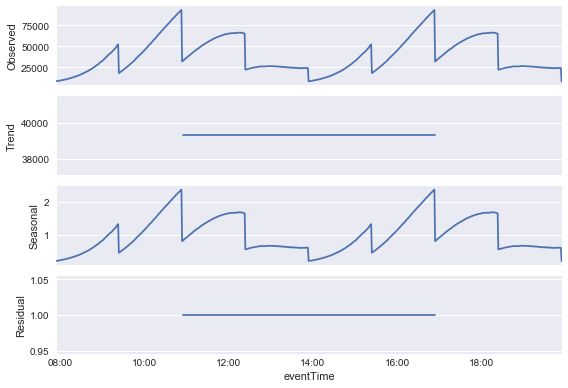

In [88]:
# Plot the decomposition of the throughput
worktime_components = sm.tsa.seasonal_decompose(worktime, model='multiplicative', freq=360)
worktime_components.plot()
plt.show()

#### 2.3.2 Forecast of worktime

** Next steps **
* Resample the data in 10 minute buckets due to seasonality
* Split the data in train and test sets
* Perform grid search over relevant parameters
* Choose best performing model
* Create forecast

Because worktime is a function of throughput and response time the seasonality corresponds with the longer season of throughput and we have 360 lags as well. 

In [89]:
# We apply same resampling procedure as above
worktime_resampled = worktime.resample('10T').sum()['2018-05-05 08:00:00':'2018-05-05 19:40:00']

# Performing split for throughput
train_data, test_data = train_test_split(worktime_resampled, .9)

Training data: 65 rows
Testing data: 6 rows


In [90]:
# Grid search over parameters for sarimax model
bic, aic, best_model = sarimax_grid_search(train_data, 36)
print('Best SARIMAX model: %s' % best_model)

Best SARIMAX model: (0, 0, 0)x(1, 0, 0, 36)


As expected the best model for worktime has the same parameter as the model for throughput.

In [91]:
# Fitting the best performaing model
results = fit_arimax_model(train_data, (0,0,0), ((1, 0, 0, 36)))

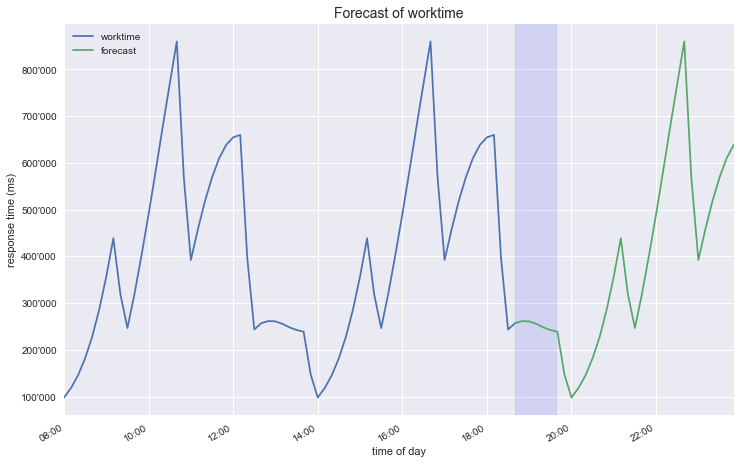

In [92]:
# Performing a one step ahead forecast
make_prediction(train_data, results, 'Forecast of worktime')

In [251]:
# Calculate the mean squred error of our predition for the test set
pred = results.get_prediction(start='2018-05-05 18:40:00', end='2018-05-05 19:40:00', dynamic=False)

calculate_mse(pred.predicted_mean, test_data)

The MSE of our forecast is 2.541098841762901e-21


Due to the resampling process we have a similar error like in the previous model for throughput.

#### 2.3.3 Variation: Forecast of worktime with an LSTM

In this not requested step I try to build a model with a long short-term memory network (LSTM) with keras and tensorflow. **This step has not been done in the provided time** and therefore should no be part of the rating. We have done this step out of interest alone with the knowing that a model like this will probably not peform that well on artifical data.

** Next steps **
* Load the data
* Create buckets of 1 minute
* Create window of observation and past observations
* Define architecture of model

In [253]:
import numpy as np
import pandas as pd
from keras.models import Sequential
from keras.layers import Dense, LSTM
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error

In [254]:
# Set seed for reproducible work with keras
from numpy.random import seed
seed(42)
from tensorflow import set_random_seed
set_random_seed(42)

In [255]:
# Selecting component
component_id = 'tm4-Himalaia-52'

# Cleaning index and relevant columns
component_events = application_events[application_events['tkNameIdProvider'] == component_id][['eventTime', 'durationMs']]
component_events.index = component_events['eventTime']
component_events.index = pd.to_datetime(component_events.index)

In [264]:
# Creating buckets of one minute
event_buckets = component_events.resample('1T').sum()

In [267]:
# Create a window with past observations (observation and x lookbacks)
window_size = 200

data_copy = event_buckets.copy()
for i in range(window_size):
    event_buckets = pd.concat([event_buckets, data_copy.shift(-(i+1))], axis = 1)
    
event_buckets.dropna(axis=0, inplace=True)

In [270]:
# Show window for validation
columns = []
for i in range(window_size+1):
    columns.append('t'+ str(i))
event_buckets.columns = columns
event_buckets.head()

,t0,t1,t2,t3,t4,t5,t6,t7,t8,t9,...,t191,t192,t193,t194,t195,t196,t197,t198,t199,t200
eventTime,,,,,,,,,,,,,,,,,,,,,
2018-05-05 07:55:00,8364,8528.0,8520.0,8680.0,8840.0,9040.0,9200.0,9360.0,9560.0,9720.0,...,40320.0,40960.0,41600.0,42400.0,43040.0,43680.0,44202.0,44838.0,45474.0,46269.0
2018-05-05 07:56:00,8528,8520.0,8680.0,8840.0,9040.0,9200.0,9360.0,9560.0,9720.0,9880.0,...,40960.0,41600.0,42400.0,43040.0,43680.0,44202.0,44838.0,45474.0,46269.0,46905.0
2018-05-05 07:57:00,8520,8680.0,8840.0,9040.0,9200.0,9360.0,9560.0,9720.0,9880.0,10080.0,...,41600.0,42400.0,43040.0,43680.0,44202.0,44838.0,45474.0,46269.0,46905.0,47242.0
2018-05-05 07:58:00,8680,8840.0,9040.0,9200.0,9360.0,9560.0,9720.0,9880.0,10080.0,10240.0,...,42400.0,43040.0,43680.0,44202.0,44838.0,45474.0,46269.0,46905.0,47242.0,48032.0
2018-05-05 07:59:00,8840,9040.0,9200.0,9360.0,9560.0,9720.0,9880.0,10080.0,10240.0,10400.0,...,43040.0,43680.0,44202.0,44838.0,45474.0,46269.0,46905.0,47242.0,48032.0,48664.0


In [332]:
# Create matrix input for keras
y = event_buckets.iloc[:, 0].as_matrix()
X = event_buckets.iloc[:, 1:].as_matrix()

In [335]:
# Scale data down for the lstm network
x_scaler = MinMaxScaler(feature_range=(0, 1))
y_scaler = MinMaxScaler(feature_range=(0, 1))

X = x_scaler.fit_transform(X)
y = y_scaler.fit_transform(y.reshape(-1,1))

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:429: DataConversionWarning: Data with input dtype int64 was converted to float64 by MinMaxScaler.
  warnings.warn(msg, _DataConversionWarning)


In [336]:
# Split the data in train and test sets
train_size = .75
split_index = int(X.shape[0] * train_size)

X_train = X[:split_index, :]
y_train = y[:split_index]

X_test = X[split_index:, ]
y_test = y[split_index:]

In [337]:
# Convert the input matrices to a lstm input (samples, time steps, features)
X_train = np.reshape(X_train, (X_train.shape[0], 1, X_train.shape[1]))
X_test = np.reshape(X_test, (X_test.shape[0], 1, X_test.shape[1]))

In [338]:
# Define the network architecture
model = Sequential()
model.add(LSTM(200, input_shape=(1, 200)))
model.add(Dense(1, activation='tanh'))
model.compile(loss='mean_squared_error', optimizer='adam')

# Display summary of layers
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_2 (LSTM)                (None, 200)               320800    
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 201       
Total params: 321,001
Trainable params: 321,001
Non-trainable params: 0
_________________________________________________________________


** Next steps **
* Train the model
* Make prediction
* Plot forecast
* Evaluate metrics

In [339]:
from keras.callbacks import ModelCheckpoint  
import livelossplot as lp

# Define number of training cycles
epochs = 100

# Defining checkpoints for plotting and saving
plot_callback = lp.PlotLossesKeras()
checkpointer = ModelCheckpoint(filepath='lstm.hdf5', save_best_only=True)
callbacks = [checkpointer, plot_callback]

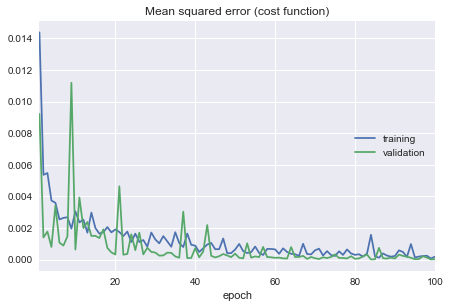

In [340]:
# Train the model
model.fit(X_train, y_train, epochs=epochs, validation_data=(X_test, y_test)
          , verbose=1, batch_size=1, callbacks=callbacks)

As we can see, there is no overfitting and the gradient is steadily descending. This also shows the mathematical nature of our signal

In [341]:
# Make prediction from trained model
train_pred = model.predict(X_train)
test_pred = model.predict(X_test)

In [342]:
# Scale predictions back to original scale
train_pred = y_scaler.inverse_transform(train_pred)
test_pred = y_scaler.inverse_transform(test_pred)

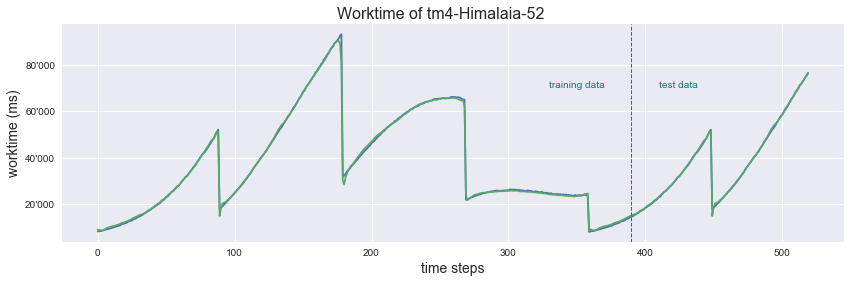

In [346]:
# Plot training and testing prediction together with original data
fig, ax = plt.subplots(1, figsize=(14, 4))

plt.suptitle('Worktime of '+ component_id, fontsize=16, y=.94)

ax.plot(y_scaler.inverse_transform(y))
ax.plot(np.append(train_pred, test_pred))
ax.axvline(y_train.shape[0], linestyle='--', c='teal', linewidth=1)
ax.yaxis.set_major_formatter(thousand_formatter) 
ax.set_xlabel('time steps', fontsize=14)
ax.set_ylabel('worktime (ms)', fontsize=14)
ax.text(330, 7e4, 'training data', color='teal')
ax.text(410, 7e4, 'test data', color='teal')
plt.show()

In [349]:
import math

# Calculate mean squared error in original scale
print('RMSQ is: %.2f' % math.sqrt(mean_squared_error(y_scaler.inverse_transform(y_test), test_pred)))

RMSQ is: 433.21


With this model we achieve a root mean squared error of around half e second. This is not even close to the performance of the models before. The necessary scaling of the data might be an issue here.

### 3. Correlating the layers

** Next steps **
* Load the data of all the layers
* Correlate the layers with the common key
* Plot the graph of the layers
* Find the event sequence

In [1]:
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import locale
import numpy as np
import pandas as pd

In [2]:
# We filter application events and select relevant columns
chosen_component_id = 'tm4-Himalaia-52'
application_events = pd.read_json('D:\\events\\applications.json')
application_events = application_events[application_events['tkNameIdProvider'] == chosen_component_id]

application_events = application_events.rename(columns={
    'callId': 'callId-app','correlationId': 'corrID','eventTime': 'logTime-app'})

In [3]:
# Import the data from the web entry server
wes_events = pd.read_json('D:\\events\\wes.json')
wes_events = wes_events.rename(columns={'callId': 'callId-wes','logTime': 'logTime-wes'})

In [4]:
# Import the data from the apache web server
apache_events = pd.read_json('D:\\events\\apache.json')
apache_events = apache_events.rename(columns={'callId': 'callId-apache', 'logTime': 'logTime-apache'})

In [5]:
# Joining all three layers together with correlation id
application_and_wes = pd.merge(application_events, wes_events, on='corrID', how='inner')
all_layers = pd.merge(application_and_wes, apache_events, on='corrID', how='inner')

all_layers.index = all_layers['logTime-app']
all_layers.index = pd.to_datetime(all_layers.index)

In [6]:
all_layers[['logTime-app', 'logTime-wes', 'logTime-apache']].head() 

,logTime-app,logTime-wes,logTime-apache
logTime-app,,,
2018-05-05 07:55:38.436674,2018-05-05T07:55:38.436674+00:00,2018-05-05T07:55:38.446674+00:00,2018-05-05T07:55:38.466674+00:00
2018-05-05 07:55:38.461064,2018-05-05T07:55:38.461064+00:00,2018-05-05T07:55:38.471064+00:00,2018-05-05T07:55:38.491064+00:00
2018-05-05 07:55:38.485455,2018-05-05T07:55:38.485455+00:00,2018-05-05T07:55:38.495455+00:00,2018-05-05T07:55:38.515455+00:00
2018-05-05 07:55:38.509845,2018-05-05T07:55:38.509845+00:00,2018-05-05T07:55:38.519845+00:00,2018-05-05T07:55:38.539845+00:00
2018-05-05 07:55:38.534235,2018-05-05T07:55:38.534235+00:00,2018-05-05T07:55:38.544235+00:00,2018-05-05T07:55:38.564235+00:00


Log times are suggesting following order of events: _application > wes > apache_.

In [7]:
all_layers[['callId-app','callId-wes','callId-apache']].head()

,callId-app,callId-wes,callId-apache
logTime-app,,,
2018-05-05 07:55:38.436674,0,1,2
2018-05-05 07:55:38.461064,2,3,4
2018-05-05 07:55:38.485455,4,5,6
2018-05-05 07:55:38.509845,6,7,8
2018-05-05 07:55:38.534235,8,9,10


Call order does suggest same order of layers.

In [8]:
# Calculate worktime for all components (with formula for average)
all_layers_resampled = all_layers.resample('1T')
number_of_requests = all_layers_resampled['corrID'].count()
worktime_app = all_layers_resampled['durationMs'].mean() * number_of_requests
worktime_wes = all_layers_resampled['dTF'].mean() * number_of_requests
worktime_apache = (all_layers_resampled['time'].mean() / 1000) * number_of_requests

In [9]:
worktime_all_layers = pd.DataFrame({'worktime-app': worktime_app,
                          'worktime-wes': worktime_wes,
                          'worktime-apache':worktime_apache})

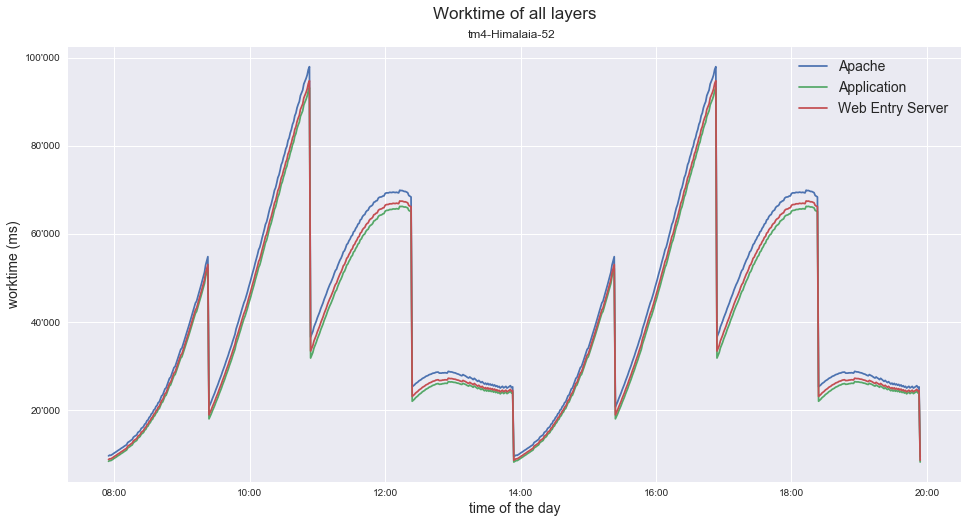

In [19]:
# Plot worktime of all layers in one graph
fig, ax = plt.subplots(1,1, figsize=(16, 8))

plt.suptitle(chosen_component_id, y=.91, x=.51)
ax.plot(worktime_all_layers)
ax.set_title('Worktime of all layers', fontsize=17, y=1.05)
ax.set_ylabel('worktime (ms)', fontsize=14)
ax.set_xlabel('time of the day', fontsize=14)

ax.xaxis.set_major_formatter(hour_formatter)
ax.yaxis.set_major_formatter(thousand_formatter)
ax.legend(['Apache', 'Application', 'Web Entry Server'], fontsize=14)

plt.show()

The graph does not allow for more interpretation than the previously mentioned. We can see that the application layer has the lowest worktime.